In [1]:
import os
import psutil
import gc
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image
import numpy as np
import matlab.engine
import h5py
import pymatreader
from pymatreader import read_mat

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
# from torchmetrics import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

# Running MATLAB code to generate simulated images.

In [2]:
# SIMULATED_IMAGES_FOLDER = 'Simulated Images/'
# ROOT_DIR = os.getcwd()
# SIMULATED_IMAGES_PATH = os.path.join(ROOT_DIR, SIMULATED_IMAGES_FOLDER)
# if os.listdir(SIMULATED_IMAGES_PATH):
#     # Start MATLAB engine
#     eng = matlab.engine.start_matlab()
#     # Specify the root folder containing your MATLAB functions
#     # root_folder = '/Users/ChiragSP/MTU/Fall 2024/BE5870/Final Project/Image Simulation Code/'
#     # Generate path string including all subfolders
#     # path_string = eng.genpath(root_folder)
    
#     # Add the generated path to MATLAB search path
#     # eng.addpath(path_string, nargout=0)
#     nExp = 20;
#     force_start = 200.0;
#     force_step = 200.0;
#     force_stop = 4000.0;
#     distance_start = 2.0;
#     distance_step = 2.0;
#     distance_stop = 20.0;
#     storePath = '/Users/ChiragSP/MTU/Fall 2024/BE5870/Final Project/Simulated Images/'
    
#     eng.CSPrunTestSingleForcePython(nExp, 
#                                     force_start, 
#                                     force_step, 
#                                     force_stop, 
#                                     distance_start, 
#                                     distance_step,
#                                     distance_stop,
#                                     storePath, 
#                                     nargout = 0)
    
#     eng.quit()
# else:
#     print("Simulated Images already present, either delete previous data or provide new path to empty directory.")

# Get all directories in 'Simulated Images' class.

In [3]:
def get_sorted_directories(directory_path):
    # Get all directories in the specified path
    directories = [d for d in Path(directory_path).iterdir() if d.is_dir()]
    
    # Sort directories by modification time
    sorted_directories = sorted(directories, key=lambda x: x.stat().st_mtime, reverse=False)
    
    return sorted_directories

# Example usage
SIMULATED_IMAGES_FOLDER = 'Simulated Images'
ROOT_DIR = os.getcwd()
SIMULATED_IMAGES_PATH = os.path.join(ROOT_DIR, SIMULATED_IMAGES_FOLDER)
sorted_dirs = get_sorted_directories(SIMULATED_IMAGES_PATH)

# for directory in sorted_dirs:
#     print(f"{directory.name}: {os.path.getmtime(directory)}")

In [4]:
len(sorted_dirs)

4000

# Extract all images, and force vectors from all directories.

In [5]:
np_files = ['bead_images.npy', 'ref_images.npy', 'force_x.npy', 'force_y.npy', 'images.npy', 'forces.npy']
all_present = True

for file in np_files:
    if not os.path.exists(os.path.join(os.getcwd(), file)):
        print(f"{file} does not exist")
        all_present = False
        
if not all_present:
    REF_IMAGE_FILE = 'Reference/img1ref.tif'
    BEAD_IMAGE_FILE = 'Beads/img2bead.tif'
    MAT_FILE = 'Original/data.mat'
    ROOT_DIR = os.getcwd()
    SIMULATED_IMAGES_PATH = os.path.join(ROOT_DIR, 'Simulated Images')
    
    
    # Extracting Bead Images.--------------------
    # Getiting shape of first image since all will be the same.
    with Image.open(os.path.join(SIMULATED_IMAGES_PATH, sorted_dirs[0], BEAD_IMAGE_FILE)) as img:
        first_image = np.array(img)
        image_shape = first_image.shape
    bead_images = np.zeros((len(sorted_dirs), *image_shape), dtype=first_image.dtype)
    
    # Extracting Reference Images.--------------------
    with Image.open(os.path.join(SIMULATED_IMAGES_PATH, sorted_dirs[0], REF_IMAGE_FILE)) as img:
        first_image = np.array(img)
        image_shape = first_image.shape
    ref_images = np.zeros((len(sorted_dirs), *image_shape), dtype=first_image.dtype)
    
    # Extracting MATLAB data--------------------
    # Extracting force in X-direction.
    DATA_PATH = os.path.join(SIMULATED_IMAGES_PATH, sorted_dirs[0], MAT_FILE)
    data = read_mat(DATA_PATH)
    temp = data['force_x'].shape
    force_x = np.zeros((len(sorted_dirs), *data['force_x'].shape))
    force_y = np.zeros((len(sorted_dirs), *data['force_y'].shape))
    
    images = np.zeros((len(sorted_dirs), np.ndim(first_image), *data['force_x'].shape), dtype=first_image.dtype)
    forces = np.zeros((len(sorted_dirs), np.ndim(data['force_x']), *image_shape), dtype=first_image.dtype)
                      
    for idx, dir in tqdm(enumerate(sorted_dirs)):
        with Image.open(os.path.join(SIMULATED_IMAGES_PATH, dir, BEAD_IMAGE_FILE)) as img:
            bead_images[idx] = np.array(img)
        with Image.open(os.path.join(SIMULATED_IMAGES_PATH, dir, REF_IMAGE_FILE)) as img:
            ref_images[idx] = np.array(img)
        images[idx] = np.stack((ref_images[idx], bead_images[idx]))
        DATA_PATH = os.path.join(SIMULATED_IMAGES_PATH, dir, MAT_FILE)
        data = read_mat(DATA_PATH)
        force_x[idx] = data['force_x']
        data = read_mat(DATA_PATH)
        force_y[idx] = data['force_y']
        forces[idx] = np.stack((force_x[idx], force_y[idx]))
       
    print(f"Final dimensions:\nNumber of reference images: {ref_images.shape[0]} of shape: {ref_images.shape[1:]}")
    print(f"Number of bead images: {bead_images.shape[0]} of shape: {bead_images.shape[1:]}")
    print(f"Force in X-direction: {force_x.shape}")
    print(f"Force in Y-direction: {force_y.shape}")
    print(f"Dimension of images: {images.shape}")
    print(f"Dimension of forces: {forces.shape}")

    np.save('bead_images.npy', bead_images)
    np.save('ref_images.npy', ref_images)
    np.save('force_x.npy', force_x)
    np.save('force_y.npy', force_y)
    np.save('images.npy', images)
    np.save('forces.npy', forces)

else:
    print("Loading files")
    bead_images = np.load('bead_images.npy')
    ref_images = np.load('ref_images.npy')
    force_x = np.load('force_x.npy')
    force_y = np.load('force_y.npy')
    images = np.load('images.npy')
    forces = np.load('forces.npy')
    print(f"Final dimensions:\nNumber of reference images: {ref_images.shape[0]} of shape: {ref_images.shape[1:]}")
    print(f"Number of bead images: {bead_images.shape[0]} of shape: {bead_images.shape[1:]}")
    print(f"Force in X-direction: {force_x.shape}")
    print(f"Force in Y-direction: {force_y.shape}")
    print(f"Dimension of images: {images.shape}")
    print(f"Dimension of forces: {forces.shape}")

Loading files
Final dimensions:
Number of reference images: 4000 of shape: (256, 256)
Number of bead images: 4000 of shape: (256, 256)
Force in X-direction: (4000, 256, 256)
Force in Y-direction: (4000, 256, 256)
Dimension of images: (4000, 2, 256, 256)
Dimension of forces: (4000, 2, 256, 256)


# Building Dataset

In [6]:
class BeforeAfterDataset(Dataset):
    def __init__(self, images, forces, transform=None):
        self.images = images  # 3D numpy array (N, H, W)
        self.forces = forces   # 3D numpy array (N, H, W)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        force = self.forces[idx]
        
        # Convert to torch tensors and add channel dimension
        image = torch.from_numpy(image).float()
        force = torch.from_numpy(force).float()
        
        if self.transform:
            image = self.transform(image)
            force = self.transform(force)
        
        return image, force

# Creating DataLoader

In [7]:
# # Split the dataset
# train_size = int(0.8 * len(full_dataset))
# test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Building basic U-Net model.

In [14]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 256x256x2
        self.e11 = nn.Conv2d(2, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # # input: 32x32x512
        # self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        # self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        # self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        # self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        # xp4 = self.pool4(xe42)

        # xe51 = relu(self.e51(xp4))
        # xe52 = relu(self.e52(xe51))
        
        # Decoder
        # xu1 = self.upconv1(xe52)
        # xu11 = torch.cat([xu1, xe42], dim=1)
        # xd11 = relu(self.d11(xu11))
        # xd12 = relu(self.d12(xd11))

        # xu2 = self.upconv2(xd12)
        xu2 = self.upconv2(xe42)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        # xu3 = self.upconv3(xe32)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [15]:
class DeviationOfTractionMagnitudeLoss(nn.Module):
    def __init__(self):
        super(DeviationOfTractionMagnitudeLoss, self).__init__()
    
    def forward(self, outputs, labels):
        # Calculate magnitudes
        pred_magnitude = torch.sqrt(outputs[:, 0, :, :]**2 + outputs[:, 1, :, :]**2)
        target_magnitude = torch.sqrt(labels[:, 0, :, :]**2 + labels[:, 1, :, :]**2)

        print(target_magnitude)
        
        # Calculate relative error (deviation)
        deviation = (pred_magnitude - target_magnitude) / (target_magnitude + 0.1)

        # Take absolute value
        abs_deviation = torch.abs(deviation)
        # print(f"deviation: {(pred_magnitude - target_magnitude) / (target_magnitude)}")
        # print(f"Deviation with small: {(pred_magnitude - target_magnitude) / (target_magnitude + 1e-8)}")
        # Mean over all dimensions except batch
        mean_deviation = torch.mean(abs_deviation, dim=(1, 2))
        
        # Return mean over batch
        return torch.mean(mean_deviation)

In [16]:
class ModifiedDTMLoss(nn.Module):
    def __init__(self, epsilon=1e-8, alpha=1.0):
        super(ModifiedDTMLoss, self).__init__()
        self.epsilon = epsilon
        self.alpha = alpha  # Weight for the false positive term
    
    def forward(self, outputs, labels):
        """
        Compute the Modified Deviation of Traction Magnitude loss.
        
        Args:
        outputs (torch.Tensor): Predicted traction forces, shape (batch, 2, height, width)
        labels (torch.Tensor): True traction forces, shape (batch, 2, height, width)
        
        Returns:
        torch.Tensor: The computed loss
        """
        assert outputs.shape == labels.shape, "Output and label shapes must match"
        assert outputs.shape[1] == 2, "Second dimension must be 2 for x and y components"
        
        # Calculate magnitudes
        pred_magnitude = torch.sqrt(outputs[:, 0, :, :]**2 + outputs[:, 1, :, :]**2)
        true_magnitude = torch.sqrt(labels[:, 0, :, :]**2 + labels[:, 1, :, :]**2)
        
        # Create a mask for non-zero true magnitudes
        non_zero_mask = (true_magnitude > self.epsilon)
        
        # Calculate relative error (deviation) for non-zero true magnitudes
        deviation = torch.where(non_zero_mask,
                                (pred_magnitude - true_magnitude) / (true_magnitude + self.epsilon),
                                torch.zeros_like(pred_magnitude))
        
        # Calculate mean absolute deviation for non-zero true magnitudes
        mean_deviation = torch.sum(torch.abs(deviation) * non_zero_mask.float()) / (non_zero_mask.sum() + self.epsilon)
        
        # Penalize false positives (predicted force where there should be none)
        false_positive_penalty = torch.mean(pred_magnitude * (~non_zero_mask).float())
        
        # Combine the losses
        total_loss = mean_deviation + self.alpha * false_positive_penalty
        
        return total_loss

In [17]:
class CombinedTractionLoss(nn.Module):
    def __init__(self, dtm_weight=0.5, mse_weight=0.5, epsilon=1e-8):
        super(CombinedTractionLoss, self).__init__()
        self.dtm_weight = dtm_weight
        self.mse_weight = mse_weight
        self.epsilon = epsilon
        self.mse_loss = nn.MSELoss(reduction='none')
    
    def forward(self, outputs, labels):
        """
        Compute the Combined Traction Loss (DTM + MSE).
        
        Args:
        outputs (torch.Tensor): Predicted traction forces, shape (batch, 2, height, width)
        labels (torch.Tensor): True traction forces, shape (batch, 2, height, width)
        
        Returns:
        torch.Tensor: The computed loss
        """
        assert outputs.shape == labels.shape, "Output and label shapes must match"
        
        # Calculate magnitudes
        pred_magnitude = torch.sqrt(outputs[:, 0, :, :]**2 + outputs[:, 1, :, :]**2)
        true_magnitude = torch.sqrt(labels[:, 0, :, :]**2 + labels[:, 1, :, :]**2)
        
        # Create a mask for non-zero true magnitudes
        non_zero_mask = (true_magnitude > self.epsilon)
        
        # DTM calculation
        deviation = torch.where(non_zero_mask,
                                (pred_magnitude - true_magnitude) / (true_magnitude + self.epsilon),
                                torch.zeros_like(pred_magnitude))
        
        dtm_loss = torch.mean(torch.abs(deviation))
        
        # MSE calculation
        mse = self.mse_loss(outputs, labels)
        mse_loss = torch.mean(mse)
        
        # Combine losses
        combined_loss = self.dtm_weight * dtm_loss + self.mse_weight * mse_loss
        
        return combined_loss

In [18]:
def check_and_clear_gpu():
    # Check if MPS (Metal Performance Shaders) is available
    if torch.backends.mps.is_available():
        # Get GPU memory usage
        gpu_memory = psutil.virtual_memory().percent
        
        print(f"GPU Memory Usage: {gpu_memory}%")
        
        # You can adjust this threshold as needed
        if gpu_memory > 40:  # If GPU is more than 90% full
            print("GPU memory is nearly full. Clearing cache...")
            
            # Clear PyTorch cache
            torch.mps.empty_cache()
            
            # Run garbage collector
            gc.collect()
            
            print("Cache cleared and garbage collected.")
        else:
            print("GPU memory is not full.")
    else:
        print("MPS (GPU) is not available on this system.")

# Run the function
check_and_clear_gpu()

GPU Memory Usage: 74.8%
GPU memory is nearly full. Clearing cache...
Cache cleared and garbage collected.


In [19]:
if __name__ == '__main__':

    full_dataset = BeforeAfterDataset(images[:500, :, :, :], forces[:500, :, :, :])

    # Split the dataset
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

    # train_loader = DataLoader(train_dataset, shuffle=True)
    # test_loader = DataLoader(test_dataset, shuffle=False)
    
    device = torch.device("mps")

    # Run the function
    check_and_clear_gpu()
    model = UNet(n_class = 2).to(device)
    # criterion = nn.MSELoss()
    # criterion = DeviationOfTractionMagnitudeLoss()
    # criterion = ModifiedDTMLoss()
    criterion = CombinedTractionLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Initialize metrics
    # ssim = StructuralSimilarityIndexMeasure().to(device)
    # psnr = PeakSignalNoiseRatio().to(device)
    
    num_epochs = 10
    for epoch in range(num_epochs):
        # print(f"Epoch: {epoch}")
        model.train()
        train_loss = 0.0
        for train, train_labels in tqdm(train_loader):
            train, train_labels = train.to(device), train_labels.to(device)
            # print(f"Train shape: {train.shape}, Train labels: {train_labels.shape}")
            optimizer.zero_grad()
            # print("Forward call starting")
            outputs = model(train)
            # print("Calculating loss now")
            # print(f"Shape of outputs: {outputs.shape}")
            # print(f"Shape of labels: {train_labels.shape}")
            loss = criterion(outputs, train_labels)
            # print("Backward Propagation now")
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        avg_train_loss = train_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print("-----------------------------")

    # Evaluation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for test, test_labels in tqdm(test_loader):
            test, test_labels = test.to(device), test_labels.to(device)
            outputs = model(test)
            loss = criterion(outputs, test_labels)
            test_loss += loss.item()
    
    # Calculate average metrics
    
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

GPU Memory Usage: 74.8%
GPU memory is nearly full. Clearing cache...
Cache cleared and garbage collected.


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/10]
Train Loss: 82302.9612
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/10]
Train Loss: 2194.5447
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/10]
Train Loss: 2106.3667
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/10]
Train Loss: 2092.5943
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/10]
Train Loss: 2035.8007
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/10]
Train Loss: 2012.3209
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/10]
Train Loss: 1887.3201
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/10]
Train Loss: 1850.1331
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/10]
Train Loss: 1679.6037
-----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/10]
Train Loss: 1549.8418
-----------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

Test Loss: 1560.6441


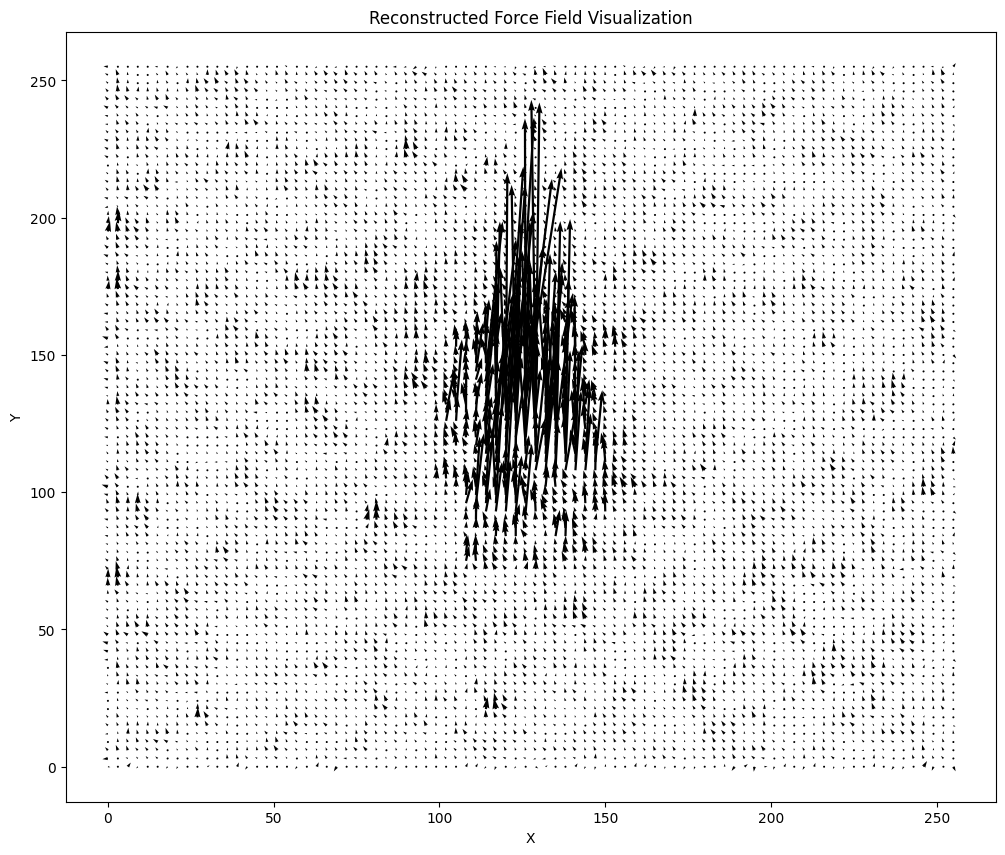

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a variable called 'forces'
# forces.shape should be (2, 256, 256)

x = np.arange(0, 256)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

# Downsample for clarity if needed
step = 3  # Adjust this to change density of arrows
plt.figure(figsize=(12, 10))
plt.quiver(X[::step, ::step], Y[::step, ::step], 
           outputs[1, 0, ::step, ::step].cpu(), outputs[1, 1, ::step, ::step].cpu())
plt.title('Reconstructed Force Field Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

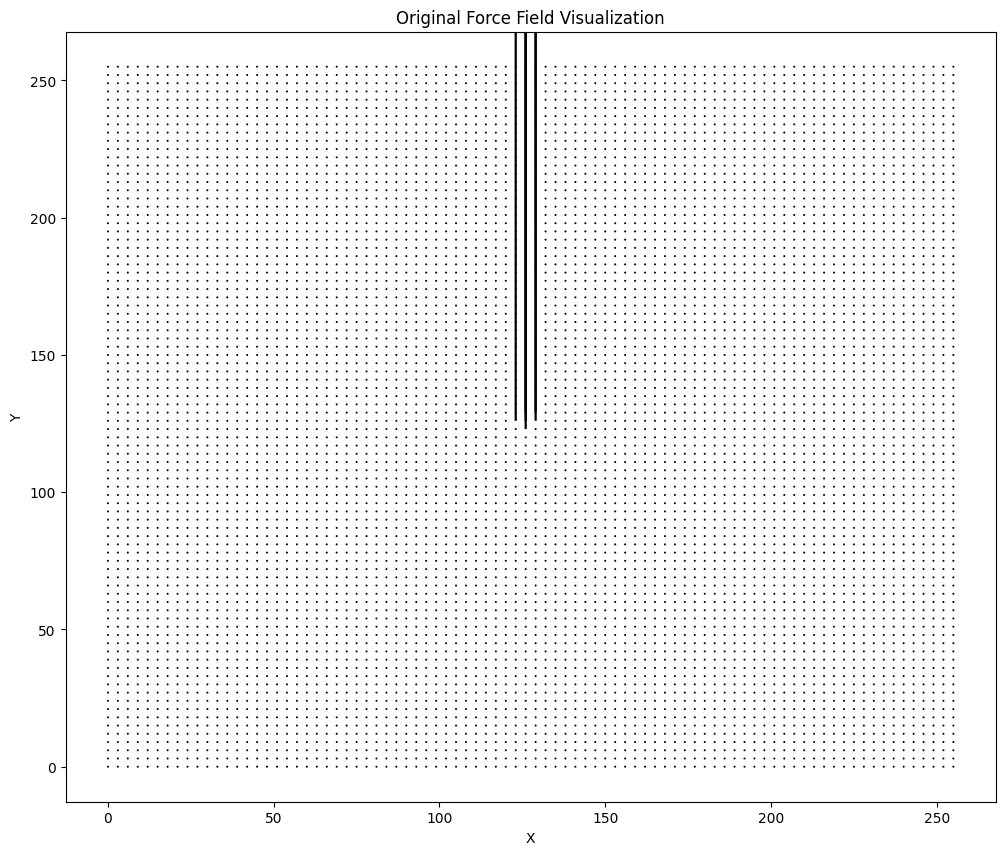

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a variable called 'forces'
# forces.shape should be (2, 256, 256)

x = np.arange(0, 256)
y = np.arange(0, 256)
X, Y = np.meshgrid(x, y)

# Downsample for clarity if needed
step = 3  # Adjust this to change density of arrows
plt.figure(figsize=(12, 10))
plt.quiver(X[::step, ::step], Y[::step, ::step], 
           forces[500, 0, ::step, ::step], forces[500, 1, ::step, ::step])
plt.title('Original Force Field Visualization')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()